<a href="https://colab.research.google.com/github/michaelchyan/MSDS422/blob/main/Module_9_NLP_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: NLP Disaster

### Management/Research Question
### In layman’s terms, what is the management/research question of interest, and why would anyone care?
The ability for a computer to recognize what shape is in an image has countless business applications, so being able to recognize numbers or text could drastically cut back on manual labor.

## Ingest

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import math, os, re, time, random, string
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

from collections import defaultdict
import wordcloud

In [158]:
train = pd.read_csv("train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [159]:
test = pd.read_csv("test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Last five rows

In [160]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


*What are the columns?*

In [161]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

*What is the shape:  i.e. rows,columns?*

In [162]:
train.shape

(7613, 5)

## EDA

In [163]:
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)

In [164]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


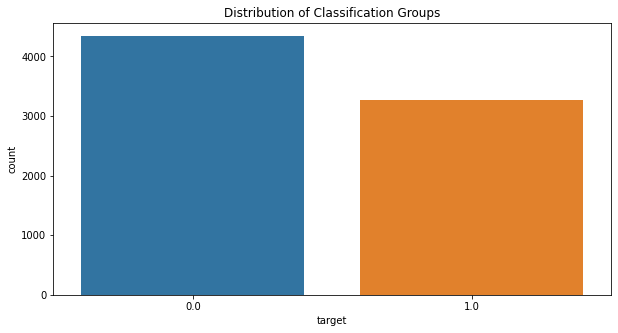

In [165]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

In [166]:
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [167]:
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic                    Times: Telegraph.co.ukTitanic tragedy could have been preve... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co ukTitanic tragedy could have been preve'

In [168]:
PROCESS_TWEETS = False
if PROCESS_TWEETS:
    #apply all of above functions
    total['text'] = total['text'].apply(lambda x: x.lower())
    total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    total['text'] = total['text'].apply(remove_punctuation)
    total['text'] = total['text'].apply(remove_stopwords)
    total['text'] = total['text'].apply(remove_less_than)
    total['text'] = total['text'].apply(remove_non_alphabet)

In [169]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [170]:
total['text'] = total['text'].apply(expand_contractions)

## Modeling

In [171]:
 def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

In [181]:
total['text'] = total['text'].apply(clean)

In [182]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

In [183]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in wordcloud.STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

###################################################
#### Unigrams
###################################################

disaster_unigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        disaster_unigrams[word] += 1
disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_unigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        nondisaster_unigrams[word] += 1
nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### Bigrams
###################################################

disaster_bigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        disaster_bigrams[word] += 1
disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_bigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        nondisaster_bigrams[word] += 1
nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### Trigrams
###################################################

disaster_trigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        disaster_trigrams[word] += 1
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_trigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        nondisaster_trigrams[word] += 1
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### 4-grams
###################################################

disaster_4grams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        disaster_4grams[word] += 1
disaster_4grams = pd.DataFrame(sorted(disaster_4grams.items(), key=lambda x: x[1])[::-1])

nondisaster_4grams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        nondisaster_4grams[word] += 1
nondisaster_4grams = pd.DataFrame(sorted(nondisaster_4grams.items(), key=lambda x: x[1])[::-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


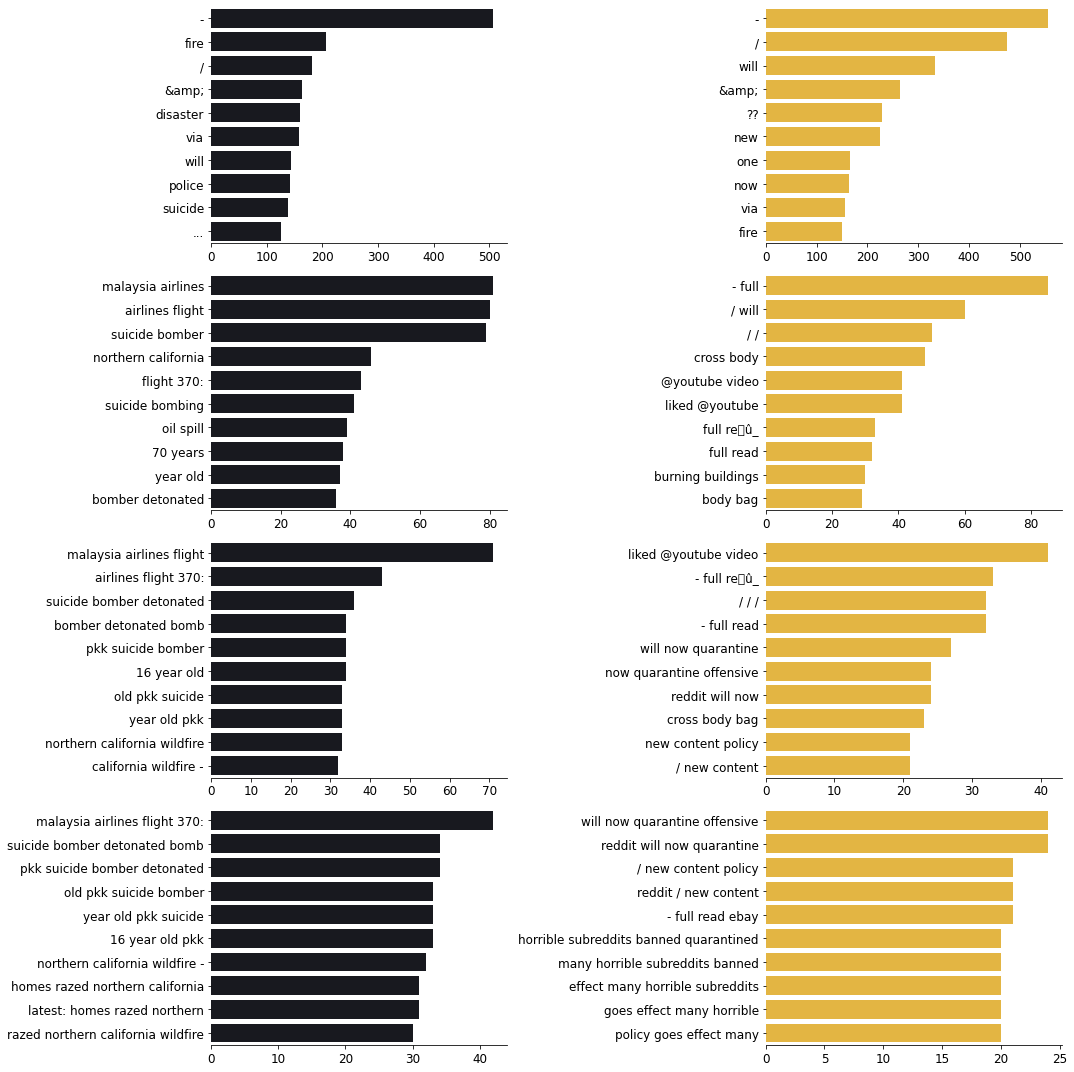

In [184]:
N = 10

fig, ax = plt.subplots(4, 2, figsize = (15, 15))
plt.tight_layout()

sns.barplot(y = disaster_unigrams[0].values[:N], x = disaster_unigrams[1].values[:N], ax = ax[0, 0], color='#171820')
sns.barplot(y = nondisaster_unigrams[0].values[:N], x = nondisaster_unigrams[1].values[:N], ax = ax[0, 1], color = '#fdc029')

sns.barplot(y = disaster_bigrams[0].values[:N], x = disaster_bigrams[1].values[:N], ax = ax[1, 0], color='#171820')
sns.barplot(y = nondisaster_bigrams[0].values[:N], x = nondisaster_bigrams[1].values[:N], ax = ax[1, 1], color = '#fdc029')

sns.barplot(y = disaster_trigrams[0].values[:N], x = disaster_trigrams[1].values[:N], ax = ax[2, 0], color='#171820')
sns.barplot(y = nondisaster_trigrams[0].values[:N], x = nondisaster_trigrams[1].values[:N], ax = ax[2, 1], color = '#fdc029')

sns.barplot(y = disaster_4grams[0].values[:N], x = disaster_4grams[1].values[:N], ax = ax[3, 0], color='#171820')
sns.barplot(y = nondisaster_4grams[0].values[:N], x = nondisaster_4grams[1].values[:N], ax = ax[3, 1], color = '#fdc029')

for i in range(0, 4):
    for j in range(0, 2):
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].tick_params(axis='x', labelsize=12)
        ax[i, j].tick_params(axis='y', labelsize=12)
    

plt.tight_layout()
plt.show()

In [185]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = "Why are you so f%#@ing angry all the time?!"
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '#': 6, '@': 7, 'ing': 8, 'angry': 9, 'all': 10, 'the': 11, 'time': 12, '?': 13, '!': 14}


In [186]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29279 unique tokens.
Shape of data tensor: (10876, 40)
Shape of label tensor: (7613,)


In [ ]:
from tqdm import tqdm

embeddings_index = {}
with open('/content/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

In [187]:
EMBEDDING_DIM = 200

#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 29279/29279 [00:00<00:00, 1372966.93it/s]

Our embedded matrix is of dimension (29280, 200)


In [188]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

#we do not want embedding layer to train since it has been pretrained

In [189]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

ValueError: ignored

In [ ]:
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [ ]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [ ]:
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

In [ ]:
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 5, batch_size = 21, verbose = 1)

### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

In [ ]:
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [ ]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

In [ ]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [ ]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
fc = get_fc_model()
fc.optimizer.lr=0.01

In [ ]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

In [ ]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model= get_cnn_model()
model.optimizer.lr=0.01

In [ ]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

In [ ]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

np.savetxt('NN_results.csv', 
           np.c_[range(1,len(test)+1), y_pred], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt = '%d')



In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

# print("Classification Report:")

# print(classification_report(y_test, pred))

# print("Confusion Report:")

# print(confusion_matrix(y_test, pred))

## Conclusion
